## Problem statement and motivation

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, the Laboratory for Innovation Science at Harvard (LISH), and the NIH Common Funds Library of Integrated Network-Based Cellular Signatures (LINCS), present this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

**What is the Mechanism of Action (MoA) of a drug? And why is it important?**

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

**How do we determine the MoAs of a new drug?**

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

**How to evaluate the accuracy of a solution?**

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

## Description of datasets

**train_features.csv** - Features for the training set. Features ```g-``` signify gene expression data, and ```c-``` signify cell viability data. ```cp_type``` indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; ```cp_time``` and ```cp_dose``` indicate treatment duration (24, 48, 72 hours) and dose (high or low). 

**train_targets_scored.csv** - The binary MoA targets that are scored.

**train_targets_nonscored.csv** - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.

**test_features.csv** - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

**sample_submission.csv** - A submission file in the correct format.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

In [3]:
train_x = pd.read_csv('data/train_features.csv', index_col=0)
train_y = pd.read_csv('data/train_targets_scored.csv', index_col=0)
train_op = pd.read_csv('data/train_targets_nonscored.csv', index_col=0)
train_x.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
print(f'train_features: {train_x.shape}\ntrain_targets_scored: {train_y.shape}\ntrain_targets_nonscored: {train_op.shape}')

train_features: (23814, 876)
train_targets_scored: (23814, 207)
train_targets_nonscored: (23814, 403)


In [7]:
print(f'Number of gene expression features: {len([col for col in train_x.columns if col.startswith("g-")])}')
print(f'Number of cell viability features: {len([col for col in train_x.columns if col.startswith("c-")])}')

Number of gene expression features: 772
Number of cell viability features: 100


In [9]:
test_x = pd.read_csv('data/test_features.csv')
print(f'test_features: {test_x.shape}')
test_x.head()

test_features: (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


## Data distribution

In [12]:
g_cols = [col for col in train_x.columns if col.startswith("g-")]
c_cols = [col for col in train_x.columns if col.startswith("c-")]

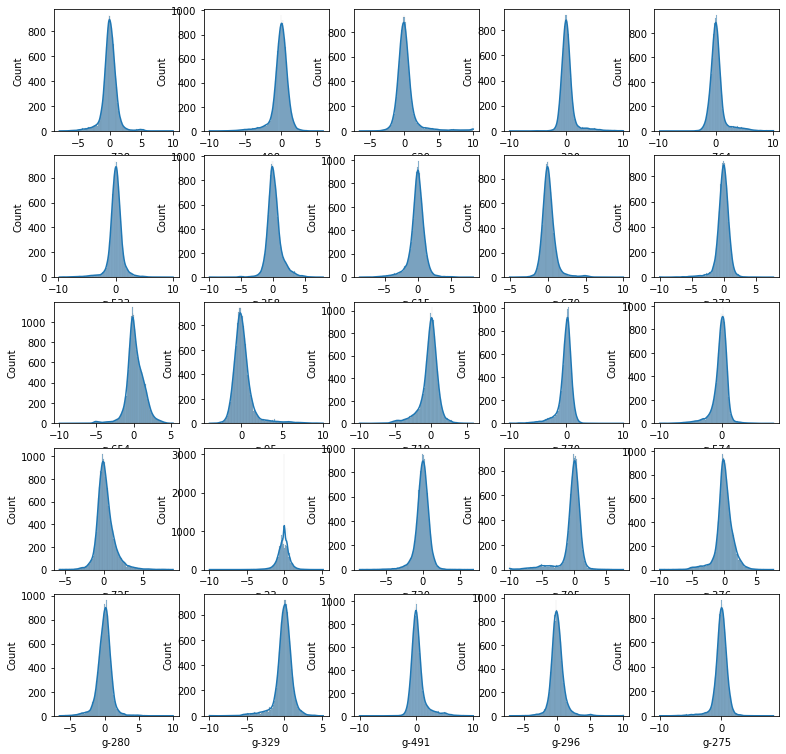

In [15]:
fig, axes = plt.subplots(5, 5, figsize=(13,13))
plot_g_cols = random.sample(g_cols, 25)
for i in range(25):
    sns.histplot(train_x[plot_g_cols[i]], ax=axes[i // 5, i % 5], kde=True)

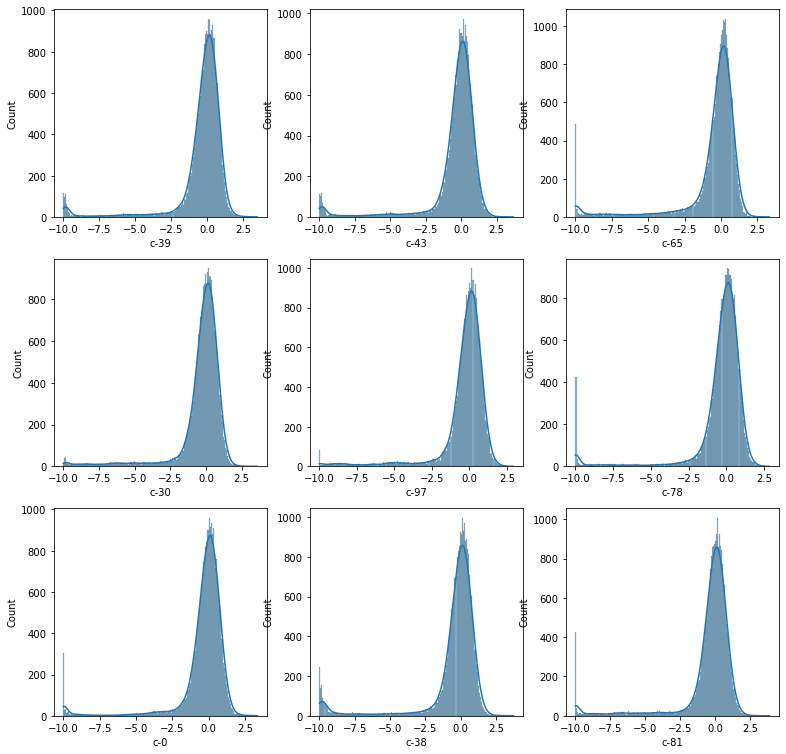

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(13,13))
plot_c_cols = random.sample(c_cols, 9)
for i in range(9):
    sns.histplot(train_x[plot_c_cols[i]], ax=axes[i // 3, i % 3], kde=True)

In [19]:
train_y.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


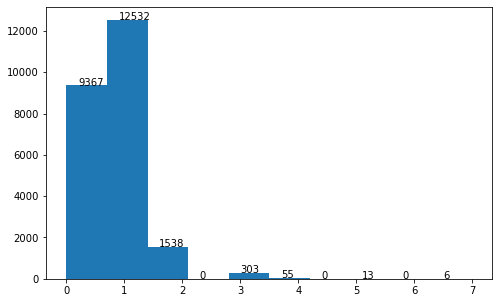

In [10]:
fig, axes = plt.subplots(figsize=(8,5))
counts, bins, _ = plt.hist(train_y.sum(axis=1))
for n, b in zip(counts, bins):
        plt.gca().text(b + 0.2, n, str(int(n)))  # +0.1 to center text
plt.show()

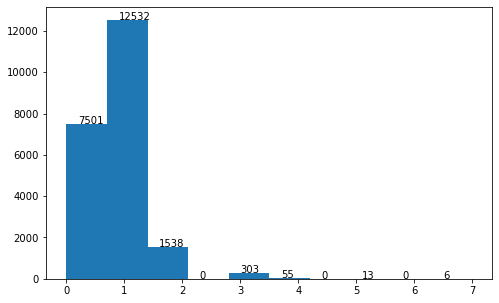

In [24]:
fig, axes = plt.subplots(figsize=(8,5))
counts, bins, _ = plt.hist(train_y[train_x.cp_type == 'trt_cp'].sum(axis=1))
for n, b in zip(counts, bins):
        plt.gca().text(b + 0.2, n, str(int(n)))  # +0.1 to center text
plt.show()

(7,501 entries with no MoAs)

## Correlation between features

<AxesSubplot:>

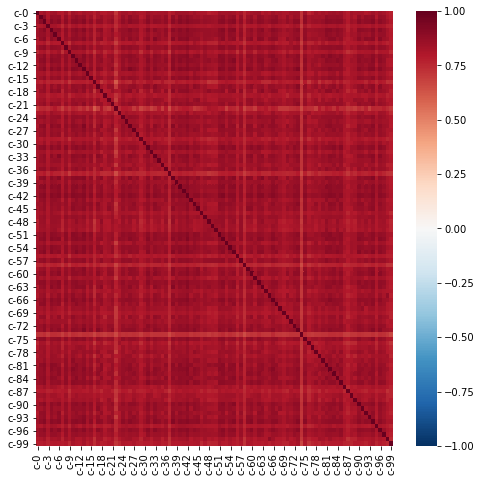

In [31]:
plt.figure(figsize=(8,8))
sns.heatmap(train_x.loc[:, c_cols].corr(), cmap='RdBu_r', vmin=-1, vmax=1)

<AxesSubplot:>

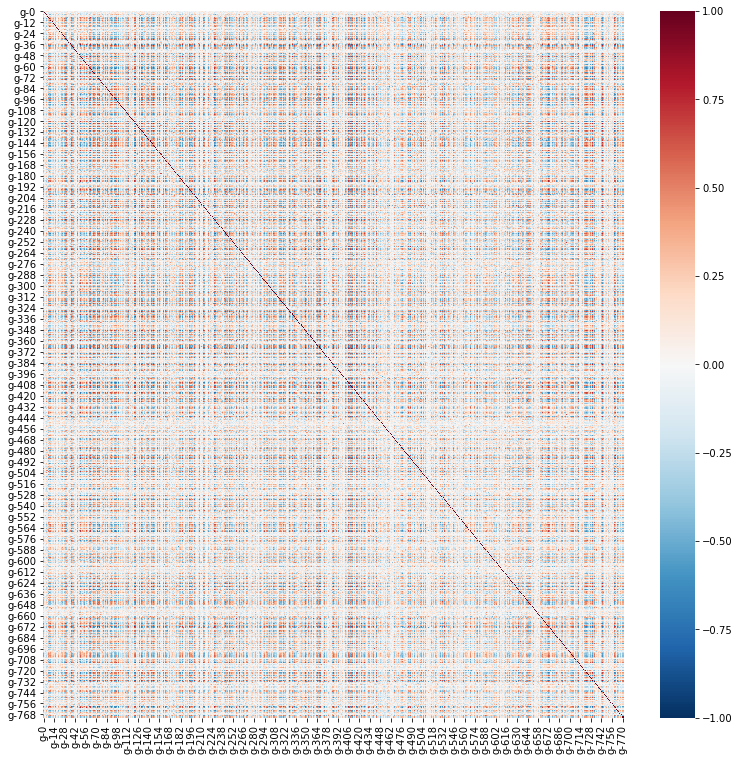

In [32]:
plt.figure(figsize=(13,13))
sns.heatmap(train_x.loc[:, g_cols].corr(), cmap='RdBu_r', vmin=-1, vmax=1)

## Summary statistics

In [16]:
train_x.groupby(['cp_type', 'cp_time', 'cp_dose']).agg(['count', 'min', 'max', 'mean'])

g-0                            g-1         \
                            count    min     max      mean count    min   
cp_type     cp_time cp_dose                                               
ctl_vehicle 24      D1        301 -2.370   3.226 -0.251760   301 -3.341   
                    D2        305 -2.135   2.601  0.010754   305 -2.597   
            48      D1        343 -3.276   3.423 -0.122773   343 -2.833   
                    D2        305 -4.859   4.335  0.013174   305 -2.878   
            72      D1        307 -2.086   2.584 -0.295271   307 -3.205   
                    D2        305 -1.909   4.670  0.070250   305 -1.660   
trt_cp      24      D1       3585 -5.183   9.908  0.367996  3585 -5.202   
                    D2       3581 -5.233   7.167  0.115253  3581 -3.109   
            48      D1       4011 -5.420  10.000  0.412469  4011 -4.333   
                    D2       3591 -4.567  10.000  0.214480  3591 -2.913   
            72      D1       3600 -5.261   9.355  0.286250  3600 -5.737   
                    D2       3580 -5.513  10.000  0.253439  3580 -3.364   

                                               g-2         ...   c-97  \
                               max      mean count    min  ...    max   
cp_type     cp_time cp_dose                                ...          
ctl_vehicle 24      D1       1.417 -0.453322   301 -1.471  ...  2.005   
                    D2       5.039 -0.229451   305 -1.412  ...  2.069   
            48      D1       1.503 -0.453638   343 -1.957  ...  2.106   
                    D2       3.745  0.001737   305 -9.104  ...  1.681   
            72      D1       1.436 -0.669059   307 -2.294  ...  2.152   
                    D2       3.252  0.133537   305 -4.148  ...  1.911   
trt_cp      24      D1       3.954 -0.170839  3585 -3.240  ...  2.748   
                    D2       3.187 -0.081764  3581 -4.845  ...  2.799   
            48      D1       2.975 -0.142581  4011 -3.123  ...  2.751   
                    D2       5.033 -0.001143  3591 -5.227  ...  2.924   
            72      D1       3.322 -0.127878  3600 -5.666  ...  2.124   
                    D2       4.676  0.052840  3580 -5.975  ...  2.321   

                                       c-98                           c-99  \
                                 mean count     min    max      mean count   
cp_type     cp_time cp_dose                                                  
ctl_vehicle 24      D1       0.282536   301  -1.678  1.894  0.350566   301   
                    D2       0.032768   305  -1.753  1.912  0.134107   305   
            48      D1       0.275933   343  -2.529  1.835  0.408657   343   
                    D2       0.179814   305  -1.517  1.760  0.232461   305   
            72      D1       0.133523   307  -3.321  1.864  0.379652   307   
                    D2       0.053252   305  -2.533  1.523  0.200942   305   
trt_cp      24      D1      -0.296366  3585 -10.000  3.111 -0.340809  3585   
                    D2      -0.226265  3581  -7.301  2.627 -0.254499  3581   
            48      D1      -0.488532  4011 -10.000  1.910 -0.634006  4011   
                    D2      -0.391335  3591 -10.000  1.945 -0.485368  3591   
            72      D1      -0.634697  3600 -10.000  1.759 -0.835132  3600   
                    D2      -0.499098  3580 -10.000  2.147 -0.644784  3580   

                                                      
                                min    max      mean  
cp_type     cp_time cp_dose                           
ctl_vehicle 24      D1       -2.715  2.233  0.342308  
                    D2       -2.258  2.193  0.112021  
            48      D1       -1.826  2.209  0.450673  
                    D2       -2.133  1.778  0.169539  
            72      D1       -3.815  1.918  0.319684  
                    D2       -2.279  1.919  0.165440  
trt_cp      24      D1       -6.426  3.120 -0.216371  
                    D2       -6.132  3.805 -0.187848  
            48      D1       -9.

In [21]:
def maxmin(x):
    g_max = x[g_cols].max().max()
    g_min = x[g_cols].min().min()
    c_max = x[c_cols].max().max()
    c_min = x[c_cols].min().min()
    return pd.Series({'g_max': g_max, 'g_min': g_min, 'c_max': c_max, 'c_min': c_min})

train_x.groupby(['cp_type', 'cp_time', 'cp_dose']).apply(maxmin)

g_max   g_min  c_max   c_min
cp_type     cp_time cp_dose                               
ctl_vehicle 24      D1       10.000 -10.000  3.438  -3.044
                    D2       10.000 -10.000  3.194  -4.683
            48      D1       10.000 -10.000  3.888  -6.510
                    D2       10.000 -10.000  2.946  -8.208
            72      D1        8.417  -9.312  2.338 -10.000
                    D2       10.000 -10.000  2.572  -9.369
trt_cp      24      D1       10.000 -10.000  6.099 -10.000
                    D2       10.000 -10.000  6.412 -10.000
            48      D1       10.000 -10.000  5.175 -10.000
                    D2       10.000 -10.000  4.235 -10.000
            72      D1       10.000 -10.000  3.846 -10.000
                    D2       10.000 -10.000  4.929 -10.000

## Treatment differences

In [44]:
cp_0.iloc[:, 2]

sig_id
id_0054388ec    D1
id_0079af0fb    D1
id_007bfbb91    D2
id_008a986b7    D2
id_009d8340f    D2
                ..
id_ff1f9e5fc    D1
id_ff469c482    D1
id_ff89331ca    D2
id_ffd26f361    D2
id_fffc1c3f4    D2
Name: cp_dose, Length: 1866, dtype: object

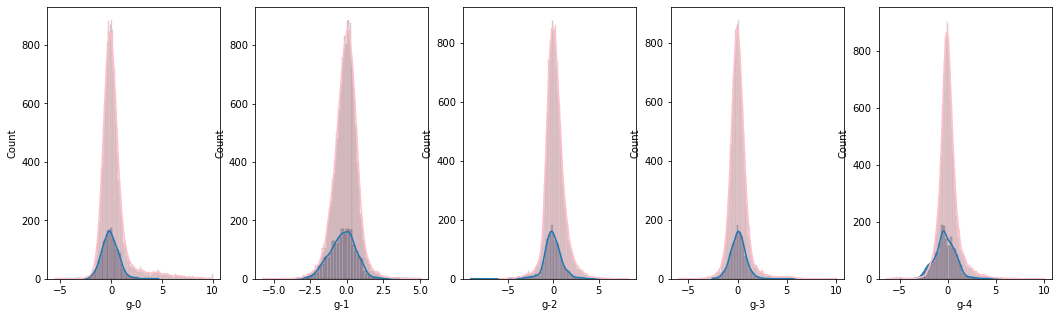

In [50]:
cp_0 = train_x[train_x['cp_type'] == 'ctl_vehicle']  # control
cp_1 = train_x[train_x['cp_type'] == 'trt_cp']  # treatment

fig, axes = plt.subplots(1, 5, figsize=(18,5))
for i in range(3, 8):
    sns.histplot(cp_0.iloc[:, i], kde=True, ax=axes[i - 3])
    sns.histplot(cp_1.iloc[:, i], color='pink', kde=True, ax=axes[i - 3])

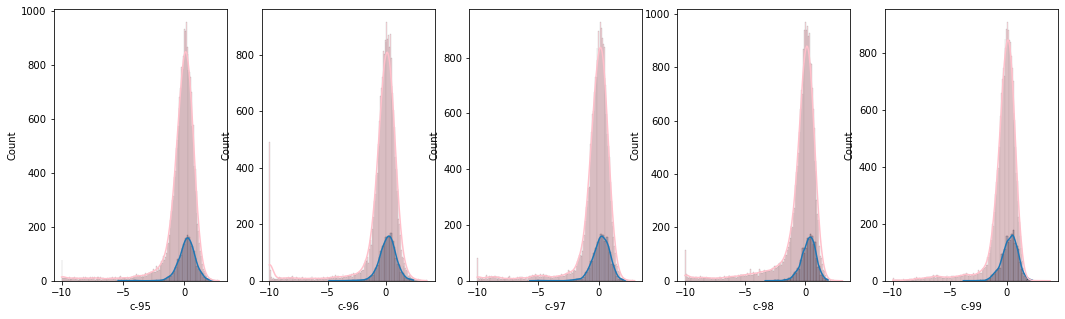

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(18,5))
for i in range(-5, 0):
    sns.histplot(cp_0.iloc[:, i], kde=True, ax=axes[i + 5])
    sns.histplot(cp_1.iloc[:, i], color='pink', kde=True, ax=axes[i + 5])

Useful background resources:

https://www.kaggle.com/c/lish-moa/discussion/184005